In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch

import pandas as pd
import numpy as np
import scanpy as sc
import os
import yaml
from pathlib import Path
from tqdm import tqdm


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
#os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.decomposition import PCA

import STG3Net as MODEL

def mapping2int(string_array):
    mapping = {}
    result = []
    for string in string_array:
        if string not in mapping:
            mapping[string] = len(mapping)
        result.append(mapping[string])
    return result, mapping

def get_data(proj_list, config):
    global graph_dict
    data_root = Path('../../data/DLPFC')
    result, mapping = mapping2int(proj_list)
    for proj_name in tqdm(proj_list):
        adata_tmp = sc.read_visium(data_root / proj_name, count_file=proj_name + "_filtered_feature_bc_matrix.h5")
        adata_tmp.var_names_make_unique()

        adata_tmp.obs['batch_name'] = proj_name
        adata_tmp.obs['slice_id'] = mapping[proj_name]

        ##### Load layer_guess label, if have
        truth_path = "../../data/DLPFC/" + proj_name + '/' + 'manual_annotations.txt'
        Ann_df = pd.read_csv(truth_path, sep='\t', header=None, index_col=0)
        Ann_df.columns = ['Ground Truth']
        adata_tmp.obs['layer_guess'] = Ann_df.loc[adata_tmp.obs_names, 'Ground Truth']
        adata_tmp = adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]

        graph_dict_tmp = MODEL.graph_construction(adata_tmp, config['k_cutoff'])
        if proj_name == proj_list[0]:
            adata = adata_tmp
            graph_dict = graph_dict_tmp
            name = proj_name
            adata.obs['proj_name'] = proj_name
        else:
            var_names = adata.var_names.intersection(adata_tmp.var_names)
            adata = adata[:, var_names]
            adata_tmp = adata_tmp[:, var_names]
            adata_tmp.obs['proj_name'] = proj_name

            adata = adata.concatenate(adata_tmp)
            graph_dict = MODEL.combine_graph_dict(graph_dict, graph_dict_tmp)
            name = name + '_' + proj_name

    adata.layers['count'] = adata.X.toarray()
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=config['top_genes'])
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)

    adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
    adata.obsm['X_pca'] = adata_X
    return adata, graph_dict

In [2]:
with open('Config/Config_DLPFC.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

proj_list = ['151673', '151674', '151675', '151676']
num_cluster = 7

adata, graph_dict = get_data(proj_list, config['data'])

100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = MODEL.G3net(adata, graph_dict=graph_dict, device=device, config=config, num_cluster=num_cluster)

In [4]:
net.train(verbose=1)

Epoch 495 total loss=0.637 recon loss=0.728 tri loss=0.000 disc loss=1.275:  50%|████▉     | 497/1000 [00:16<00:17, 28.17it/s]R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 57638 nodes or edges
Processing datasets 151674 have 45391 nodes or edges
Processing datasets 151675 have 54758 nodes or edges


Epoch 495 total loss=0.637 recon loss=0.728 tri loss=0.000 disc loss=1.275:  50%|████▉     | 497/1000 [00:32<00:17, 28.17it/s]

Processing datasets 151676 have 47700 nodes or edges


Epoch 545 total loss=0.933 recon loss=0.792 tri loss=0.246 disc loss=1.328:  55%|█████▍    | 548/1000 [00:35<00:18, 23.81it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 69286 nodes or edges
Processing datasets 151674 have 67665 nodes or edges
Processing datasets 151675 have 67111 nodes or edges
Processing datasets 151676 have 65327 nodes or edges


Epoch 595 total loss=0.899 recon loss=0.770 tri loss=0.228 disc loss=1.327:  60%|█████▉    | 599/1000 [00:53<00:15, 25.09it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 71240 nodes or edges
Processing datasets 151674 have 70439 nodes or edges
Processing datasets 151675 have 68071 nodes or edges
Processing datasets 151676 have 67533 nodes or edges


Epoch 645 total loss=0.895 recon loss=0.778 tri loss=0.217 disc loss=1.337:  65%|██████▍   | 648/1000 [01:10<00:15, 22.64it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 70430 nodes or edges
Processing datasets 151674 have 65321 nodes or edges


Epoch 645 total loss=0.895 recon loss=0.778 tri loss=0.217 disc loss=1.337:  65%|██████▍   | 648/1000 [01:22<00:15, 22.64it/s]

Processing datasets 151675 have 64546 nodes or edges
Processing datasets 151676 have 60510 nodes or edges


Epoch 695 total loss=0.855 recon loss=0.764 tri loss=0.188 disc loss=1.319:  70%|██████▉   | 697/1000 [01:29<00:13, 22.89it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 72173 nodes or edges
Processing datasets 151674 have 68226 nodes or edges
Processing datasets 151675 have 68615 nodes or edges


Epoch 695 total loss=0.855 recon loss=0.764 tri loss=0.188 disc loss=1.319:  70%|██████▉   | 697/1000 [01:42<00:13, 22.89it/s]

Processing datasets 151676 have 64130 nodes or edges


Epoch 745 total loss=0.852 recon loss=0.759 tri loss=0.187 disc loss=1.327:  75%|███████▍  | 748/1000 [01:46<00:11, 21.88it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 70432 nodes or edges
Processing datasets 151674 have 70520 nodes or edges


Epoch 745 total loss=0.852 recon loss=0.759 tri loss=0.187 disc loss=1.327:  75%|███████▍  | 748/1000 [02:02<00:11, 21.88it/s]

Processing datasets 151675 have 66191 nodes or edges
Processing datasets 151676 have 65798 nodes or edges


Epoch 795 total loss=0.836 recon loss=0.750 tri loss=0.177 disc loss=1.333:  80%|████████  | 800/1000 [02:09<00:08, 24.02it/s]

fitting ...
  |======================================================================| 100%


Epoch 795 total loss=0.836 recon loss=0.750 tri loss=0.177 disc loss=1.333:  80%|████████  | 800/1000 [02:22<00:08, 24.02it/s]

Processing datasets 151673 have 77095 nodes or edges
Processing datasets 151674 have 74925 nodes or edges
Processing datasets 151675 have 73931 nodes or edges
Processing datasets 151676 have 70640 nodes or edges


Epoch 845 total loss=0.826 recon loss=0.746 tri loss=0.170 disc loss=1.337:  85%|████████▌ | 850/1000 [02:35<00:06, 23.48it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 75885 nodes or edges
Processing datasets 151674 have 73183 nodes or edges
Processing datasets 151675 have 73545 nodes or edges
Processing datasets 151676 have 69612 nodes or edges


Epoch 895 total loss=0.834 recon loss=0.744 tri loss=0.177 disc loss=1.356:  90%|█████████ | 900/1000 [02:52<00:04, 23.35it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 77888 nodes or edges


Epoch 895 total loss=0.834 recon loss=0.744 tri loss=0.177 disc loss=1.356:  90%|█████████ | 900/1000 [03:02<00:04, 23.35it/s]

Processing datasets 151674 have 75727 nodes or edges
Processing datasets 151675 have 75600 nodes or edges
Processing datasets 151676 have 71210 nodes or edges


Epoch 945 total loss=0.834 recon loss=0.743 tri loss=0.180 disc loss=1.341:  95%|█████████▍| 949/1000 [03:09<00:02, 23.90it/s]

fitting ...
  |======================================================================| 100%
Processing datasets 151673 have 76082 nodes or edges
Processing datasets 151674 have 74650 nodes or edges
Processing datasets 151675 have 74081 nodes or edges


Epoch 945 total loss=0.834 recon loss=0.743 tri loss=0.180 disc loss=1.341:  95%|█████████▍| 949/1000 [03:22<00:02, 23.90it/s]

Processing datasets 151676 have 71625 nodes or edges


Epoch 990 total loss=0.817 recon loss=0.734 tri loss=0.171 disc loss=1.333:  99%|█████████▉| 990/1000 [03:26<00:02,  4.79it/s]

Stop trainning because of loss convergence


In [5]:
enc_rep, recon = net.process()
enc_rep = enc_rep.data.cpu().numpy()
recon = recon.data.cpu().numpy()
adata.obsm['latent'] = enc_rep
adata.obsm['recon'] = recon
print(adata)

AnnData object with n_obs × n_vars = 14243 × 2000
    obs: 'in_tissue', 'array_row', 'array_col', 'batch_name', 'slice_id', 'layer_guess', 'proj_name', 'batch', 'Tmp_domain'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'spatial', 'X_pca', 'latent', 'recon'
    layers: 'count'


In [6]:
adata = net.clustering(adata, num_cluster=num_cluster, used_obsm='latent', key_added_pred='mclust', method='mclust', random_seed=666)

fitting ...
  |======================================================================| 100%


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score

In [8]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
ARI = ari_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total ARI:{ARI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

total ARI:0.5744503792000225
151673 ARI:0.5594731633767985
151674 ARI:0.5922878525373881
151675 ARI:0.593320368678501
151676 ARI:0.5601336986039572


In [9]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
NMI = nmi_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total NMI:{NMI}")
AMI = ami_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total AMI:{AMI}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    AMI = ami_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} ACC:{ACC}")

total NMI:0.7075161697309121
total AMI:0.7073161748565533
151673 ACC:0.7092408082955215
151674 ACC:0.7301205800116757
151675 ACC:0.7209004300897017
151676 ACC:0.6977984767410048


In [10]:
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
HOM = hom_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total HOM:{HOM}")
COM = com_score(sub_adata.obs['layer_guess'], sub_adata.obs['mclust'])
print(f"total COM:{COM}")
for name in proj_list:
    sub_adata_tmp = sub_adata[sub_adata.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    COM = com_score(sub_adata_tmp.obs['layer_guess'], sub_adata_tmp.obs['mclust'])
    V =  2 * ((HOM * COM) / (HOM + COM))
    print(f"{name} V:{V}")

total HOM:0.7093766816667334
total COM:0.7056653915511274
151673 V:0.7096399103044396
151674 V:0.7304820278877372
151675 V:0.7212811045237149
151676 V:0.6982306196573586


2.714256643148504
1.0756080765182685


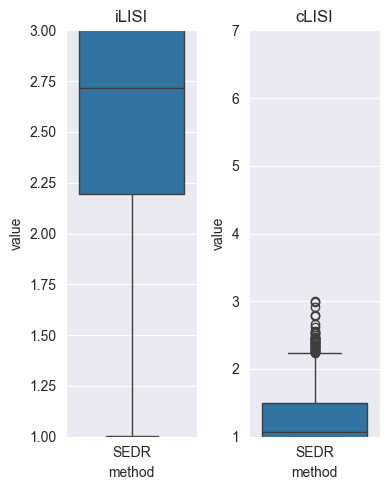

In [11]:
import harmonypy as hm

iLISI = hm.compute_lisi(adata.obsm['latent'], adata.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata.obsm['latent'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]

df_iLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

In [9]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

In [ ]:
sc.pp.neighbors(adata, use_rep='latent', metric='cosine', n_neighbors=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['mclust'], show=True, size=25, save=False)
sc.pl.umap(adata, color=['layer_guess'], show=True, size=25, save=False)
sc.pl.umap(adata, color=['batch_name'], show=True, size=25, save=False)

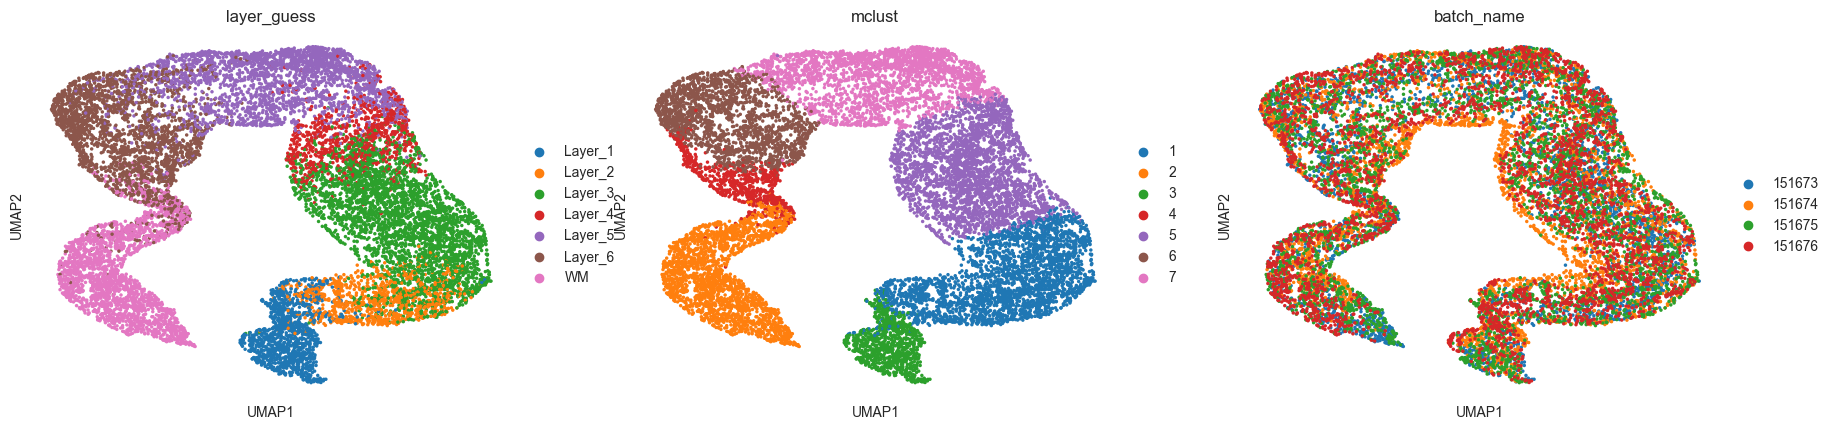

In [11]:
# %%
sc.pp.neighbors(adata, use_rep='latent', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['layer_guess', 'mclust', 'batch_name'], show=True, size=25, save=False)

In [13]:
Batch_list = []
for section_id in proj_list:
    Batch_list.append(adata[adata.obs['batch_name'] == section_id])

spot_size = 200
title_size = 12
ARI_list = []
for bb in range(len(proj_list)):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['layer_guess'], Batch_list[bb].obs['mclust']), 3))


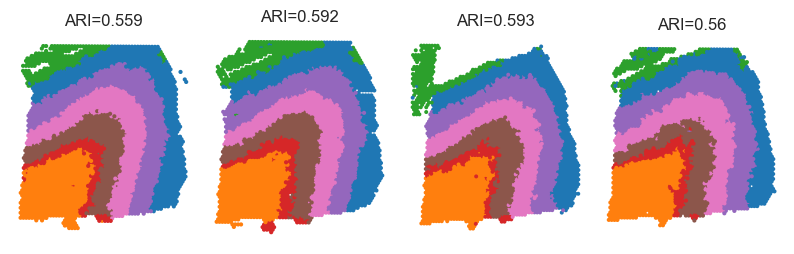

In [14]:

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx in range(len(proj_list)):
    _sc_ = sc.pl.spatial(Batch_list[idx], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                      spot_size=spot_size)
    _sc_[0].set_title("ARI=" + str(ARI_list[idx]), size=title_size)
plt.show()

In [9]:
plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

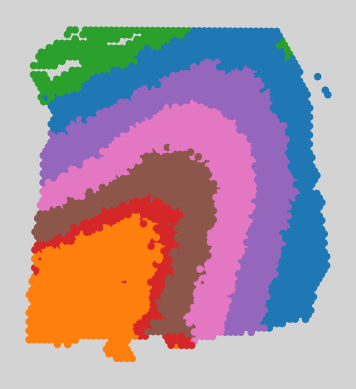

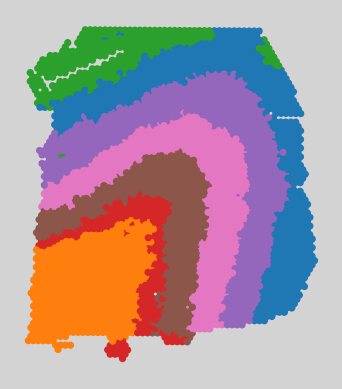

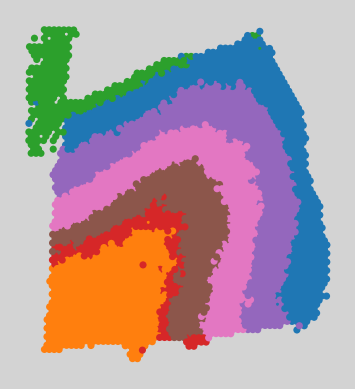

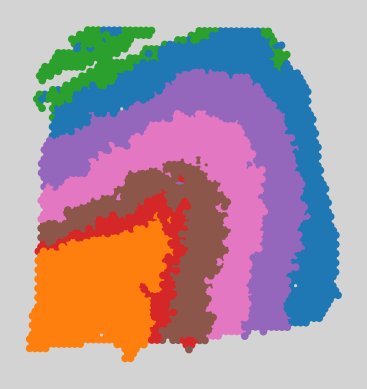

In [12]:
for section_id in proj_list:
    adata_tep = adata[adata.obs['batch_name'] == section_id]
    sc.pl.spatial(adata_tep, img_key=None, color=['mclust'], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, frameon=False,
                         spot_size=200)
    
    plt.savefig('result/'+'STG3Net_'+section_id+'.png', dpi=300, bbox_inches='tight')